In [3]:
import torch
from Model.Modelv3withAtt.ConvModelV3 import GatedGCNModel
from NPZGraphDataset import NPZGraphDataset
from pathlib import Path
import pandas as pd

ckpt_path = "./v3withAtt.pt"  # 你保存的文件路径
checkpoint = torch.load(ckpt_path, map_location="cpu")  # 或 'cuda' 

/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_67192/3898305089.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

In [4]:
# === 1) 重新实例化模型 ===
model = GatedGCNModel(
    layers_in_conv=3,
    channels=64,
    use_nodetype_coeffs=False,
    num_node_types=0,
    num_edge_types=4,
    use_jumping_knowledge=False,
    use_bias_for_update=True,
    use_dropout=True,
    num_convs=3,
    num_fc_layers=3,
    neighbors_aggr='add',
    dropout_p=0.1,
    num_targets=1,
    geom_K=16,          # <--- 新增：RBF 基数
    geom_rmax=4.0,      # <--- 新增：RBF 最大半径
    concat_original_edge=True,  # 与原 4 维边特征拼接
    heads=4,
)

model.load_state_dict(checkpoint["model_state"])
model.eval()

# === 2) 还原标准化参数 ===
y_mean = checkpoint["y_mean"]
y_std  = checkpoint["y_std"]

def denorm(t):
    return t * y_std + y_mean

In [5]:
manifest_path = Path("./graph_npz/manifest.csv")
root_dir = Path("./")  # 若 file_path 是相对路径，作为公共前缀

manifest = pd.read_csv(manifest_path)

In [6]:
from sklearn.model_selection import train_test_split

if "label" in manifest:
    # 这里用 10 个分箱；你也可以改成 5 或 20
    try:
        bins = pd.qcut(manifest["label"], q=10, duplicates="drop")
        stratify_labels = bins.astype(str)
    except Exception:
        stratify_labels = None
else:
    stratify_labels = None

# 3) 先切出测试集（10%），再从剩余里切验证集（10%）
train_val_df, test_df = train_test_split(
    manifest,
    test_size=0.10,
    random_state=42,
    shuffle=True,
    stratify=stratify_labels if stratify_labels is not None else None,
)
# 对 train_val 再按 10% 切出 val => 0.9 * 0.1 = 9%（接近 80/10/10）
if stratify_labels is not None:
    train_val_bins = pd.qcut(train_val_df["label"], q=10, duplicates="drop")
    stratify_trainval = train_val_bins.astype(str)
else:
    stratify_trainval = None

In [7]:
from torch_geometric.loader import DataLoader
test_dataset = NPZGraphDataset(
    manifest=test_df,
    root=root_dir,
    separate_pos=True,
    feature_cols=(0,1,2,3),
    coord_cols=(4,5,6),
    standardize_y=True,
)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, pin_memory=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds, trues = [], []
with torch.no_grad():
    for batch in test_loader:  # 之前构建的 test_loader
        batch = batch.to(device)
        pred_norm = model(batch)                     # 标准化空间
        y_norm = batch.y.view(-1,1).float().to(device)
        # 反标准化
        pred_k = denorm(pred_norm.cpu())
        y_k = denorm(y_norm.cpu())
        preds.append(pred_k)
        trues.append(y_k)

preds = torch.cat(preds).view(-1).numpy()
trues = torch.cat(trues).view(-1).numpy()

In [9]:
import numpy as np

mae = np.mean(np.abs(preds - trues))
rmse = np.sqrt(np.mean((preds - trues)**2))
print(f"Test MAE = {mae:.3f} K, RMSE = {rmse:.3f} K")

Test MAE = 25.876 K, RMSE = 38.310 K


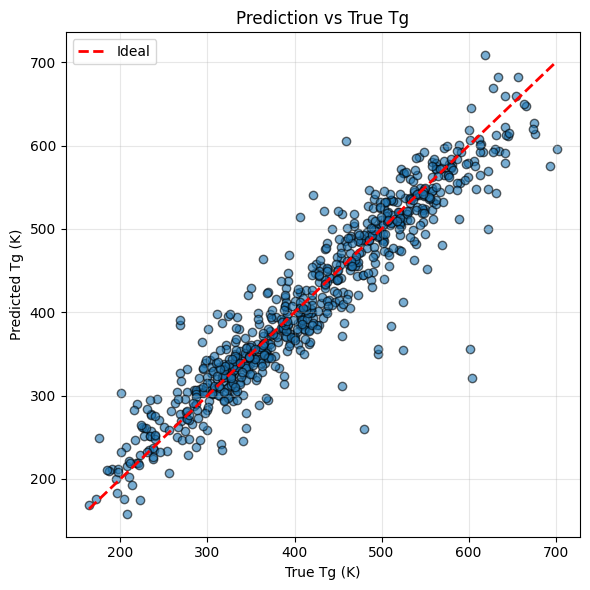

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(trues, preds, alpha=0.6, edgecolor="k")
plt.plot([trues.min(), trues.max()],
         [trues.min(), trues.max()],
         "r--", lw=2, label="Ideal")
plt.xlabel("True Tg (K)")
plt.ylabel("Predicted Tg (K)")
plt.title("Prediction vs True Tg")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig(f"v3pre.png", dpi=200)